In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

c:\Users\Joaquín Amat\Documents\GitHub\skforecast


# Sktime pipeline equivalent in skforecast

[Sktime](www.sktime.org), a well know forecasting library, allow to add transformations to the target variable as well as to exogenous variables using two different clases:

+ `TransformedTargetForecaster`: applies the given transformers the target series `y`.

+ `ForecastingPipeline`: applies the given transformers to the exogenous variables `X` before passing them to the forecaster.

[Skforecast](www.skforecast.org), also allows to add transformations to the target variable and to exogenous variables using by using the arguments:

+ `transformer_y` (`transformer_series` in multi-series forecaster): applies the given transformers to the target series `y`.

+ `transformer_exog`: applies the given transformers to the exogenous variables `exog`.

The follwing document shows side by side the equivalent code in sktime and skforecast to apply transformations to the target variable and to exogenous variables.

In [ ]:
# Libraries
# ======================================================================================
import pandas as pd
import numpy as np

from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.exponent import ExponentTransformer
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sklearn.preprocessing import PowerTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA

In [3]:
# Data
# ======================================================================================
data = fetch_dataset(name='fuel_consumption')
data = data.rename(columns={'Gasolinas': 'litters'})
data = data.rename_axis('date')
data = data.loc[:'1990-01-01 00:00:00']
data = data[['litters']]
display(data.head(4))

fuel_consumption
----------------
Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.
Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and
Corporación de Derecho Público tutelada por el Ministerio para la Transición
Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas
Shape of the dataset: (644, 5)


,litters
date,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164


In [4]:
# Exogenous variables
# ======================================================================================
data['month'] = data.index.month
data["year"] = data.index.year

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


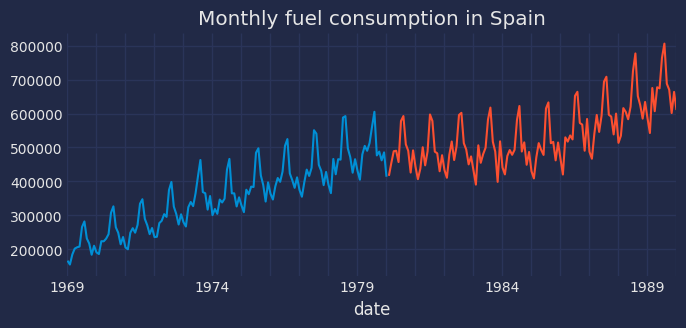

In [5]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train['litters'].plot(ax=ax, label='train')
data_test['litters'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain');

In [6]:
# Exogenous variables
# ======================================================================================
data['month'] = data.index.month
data["year"] = data.index.year

## Sktime

In [ ]:
# Wrap the Ridge regressor into a forecaster
ridge_forecaster = make_reduction(Ridge(random_state=987), window_length=15, strategy="recursive")

# Define the transformed target forecaster
pipe_y = TransformedTargetForecaster(
    steps=[
        ("boxcox", BoxCoxTransformer()),
        #("differencer", Differencer(lags=1)),
        ("forecaster", ridge_forecaster),
    ]
)

# Define the full forecasting pipeline
pipe_X = ForecastingPipeline(
    steps=[
        ("scaler", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", pipe_y),
    ]
)

# Fit the pipeline
pipe_X.fit(y=data_train['litters'], X=data_train[['month', 'year']])

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('boxcox',
                                                                BoxCoxTransformer()),
                                                               ('forecaster',
                                                                RecursiveTabularRegressionForecaster(estimator=Ridge(random_state=987),
                                                                                                     window_length=15))]))])

In [38]:
# Predict
# ======================================================================================
predictions_sktime = pipe_X.predict(fh=np.arange(1, len(data_test)+1), X=data_test[['month', 'year']])
predictions_sktime

1980-02-01    432122.714687
1980-03-01    468515.506804
1980-04-01    505028.869638
1980-05-01    495166.671792
1980-06-01    516763.261276
                  ...      
1989-09-01    818557.311281
1989-10-01    799481.895341
1989-11-01    752777.145738
1989-12-01    793736.407776
1990-01-01    745288.090850
Freq: MS, Name: litters, Length: 120, dtype: float64

Once the pipeline is fitted, it can be used to make predictions. The predict method receives the exogenous variables in the same format as the fit method.

## Skforecast

In [39]:
from skforecast.recursive import ForecasterRecursive

In [ ]:
forecaster = ForecasterRecursive(
    regressor=Ridge(random_state=987),
    lags = 15,
    transformer_y=PowerTransformer(method='box-cox', standardize=False),
    transformer_exog=StandardScaler(),
    #differentiation=1
)
forecaster.fit(y=data_train['litters'], exog=data_train[['month', 'year']])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: Ridge 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: None 
Window size: 15 
Exogenous included: True 
Exogenous names: month, year 
Transformer for y: PowerTransformer(method='box-cox', standardize=False) 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('1980-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 987, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-12-09 00:40:44 
Last fit date: 2024-12-09 00:40:44 
Skforecast version: 0.15.0 
Python version: 3.12.4 
Forecaster id: None

In [41]:
predictios_skforecast = forecaster.predict(steps=len(data_test), exog=data_test[['month', 'year']])
predictios_skforecast

1980-02-01    429592.123394
1980-03-01    489602.274079
1980-04-01    527424.917462
1980-05-01    509458.369622
1980-06-01    535806.502565
                  ...      
1989-09-01    801196.006727
1989-10-01    784173.775468
1989-11-01    818360.824406
1989-12-01    774577.771602
1990-01-01    713990.442215
Freq: MS, Name: pred, Length: 120, dtype: float64

In [42]:
pd.DataFrame({
    'sktime': predictions_sktime,
    'skforecast': predictios_skforecast,
})

,sktime,skforecast
1980-02-01,432122.714687,429592.123394
1980-03-01,468515.506804,489602.274079
1980-04-01,505028.869638,527424.917462
1980-05-01,495166.671792,509458.369622
1980-06-01,516763.261276,535806.502565
...,...,...
1989-09-01,818557.311281,801196.006727
1989-10-01,799481.895341,784173.775468
1989-11-01,752777.145738,818360.824406
1989-12-01,793736.407776,774577.771602


## Equivalent transformations

The following table shows the equivalent transformations in sktime and skforecast:

In [ ]:
# Log transformation
# ======================================================================================
from sklearn.preprocessing import FunctionTransformer
from sktime.transformations.series.boxcox import LogTransformer
transformer_sktime = LogTransformer(offset=1)
y_hat_sktime = transformer_sktime.fit_transform(data_train['litters'])
transformer_skforeast = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)
y_hat_skforecast = transformer_skforeast.fit_transform(data_train[['litters']]).flatten()
np.testing.assert_allclose(y_hat_sktime, y_hat_skforecast)

c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


In [ ]:
# Box-Cox transformation
# ======================================================================================
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sklearn.preprocessing import PowerTransformer
transformer_sktime = BoxCoxTransformer()
y_hat_sktime = transformer_sktime.fit_transform(data_train['litters'])
transformer_skforeast = PowerTransformer(method='box-cox', standardize=False)
y_hat_skforecast = transformer_skforeast.fit_transform(data_train[['litters']]).flatten()
np.testing.assert_allclose(y_hat_sktime, y_hat_skforecast)

In [ ]:
# Differencing
# ======================================================================================
from sktime.transformations.series.difference import Differencer
from skforecast.preprocessing import TimeSeriesDifferentiator
transformer_sktime = Differencer(lags=1)
y_hat_sktime = transformer_sktime.fit_transform(data_train['litters'])[1:]
transformer_skforeast = TimeSeriesDifferentiator(order=1)
y_hat_skforecast = transformer_skforeast.fit_transform(data_train['litters'].to_numpy())[1:]
np.testing.assert_allclose(y_hat_sktime, y_hat_skforecast)

## Grid search

In [ ]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("minmax", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

# using dunder notation to access inner objects/params as in sklearn
param_grid = {
    # deseasonalizer
    "deseasonalizer__model": ["multiplicative", "additive"],
    # power
    "power__transformer__method": ["yeo-johnson", "box-cox"],
    "power__transformer__standardize": [True, False],
    # forecaster
    "forecaster__sp": [4, 6, 12],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__trend": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),  # set custom scoring function
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)